# Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters

In [18]:
N = 1_000_000       # Total Population
D = 5.0            # Infection duration (days)
gamma = 1.0 / D     # Recovery rate
delta = 1.0 / 5.0   # Incubation rate (1/5 days)
rho = 1/9           # Rate from infection to death (1/9 days)
alpha = 0.05        # Death rate
R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5
v01 = 30             # Beginning of vaccination phase 1

def beta(t):
    r0_t = (R_0_start - R_0_end) / (1 + np.exp(-k * (-t + x0))) + R_0_end
    return r0_t * gamma
def heaviside(t, start_day):
    return 1.0 if t >= start_day else 0.0

# No Vaccination (Lockdown at t=50)

In [7]:
def deriv_phase0(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp = y
    
    # Phase 1 Parameters
    dSdt = -beta(t) * I / N * S 
    dEdt = beta(t) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Plotting

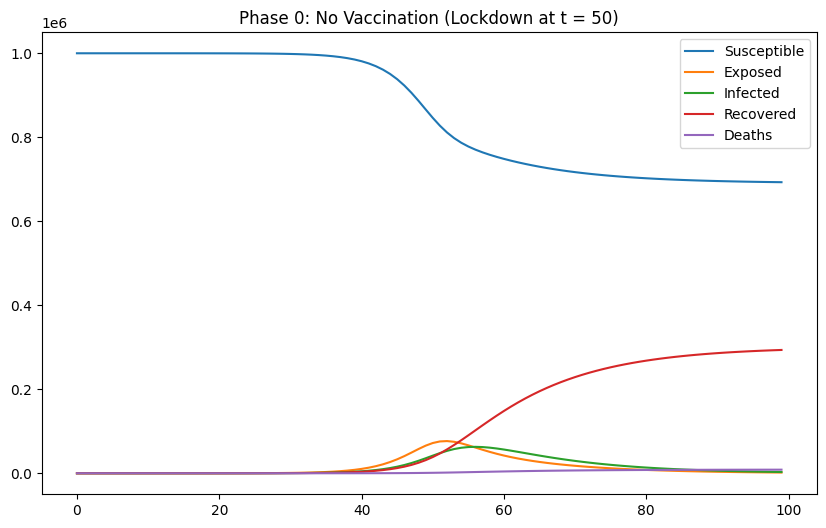

<Figure size 640x480 with 0 Axes>

In [19]:
t = np.linspace(0, 99, 100)
y0_phase0 = (N-1, 1, 0, 0, 0)
ret = odeint(deriv_phase0, y0_phase0, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final = ret.T

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final, label="Deaths")
plt.legend()
plt.title("Phase 0: No Vaccination (Lockdown at t = "+str(x0)+str(")"))
plt.show()
plt.savefig("No Vaccination x0="+str(x0))

# Single Dose with 100% immunity

In [15]:
def deriv_phase1(y, t, N, gamma, delta, rho, alpha):
    S, E, I, R, D_comp, V = y
    
    # Phase 1 Parameters
    vac_rate = 0.01   # vaccination rate
    vac_start = v01    # Starting day of vaccination
    vaccination_flow = vac_rate * S * heaviside(t, vac_start)   # No of individuals vaccinated in each day
    
    dSdt = -beta(t) * I / N * S - vaccination_flow
    dEdt = beta(t) * I / N * S - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    dVdt = vaccination_flow 
    
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt

In [11]:
## Plotting

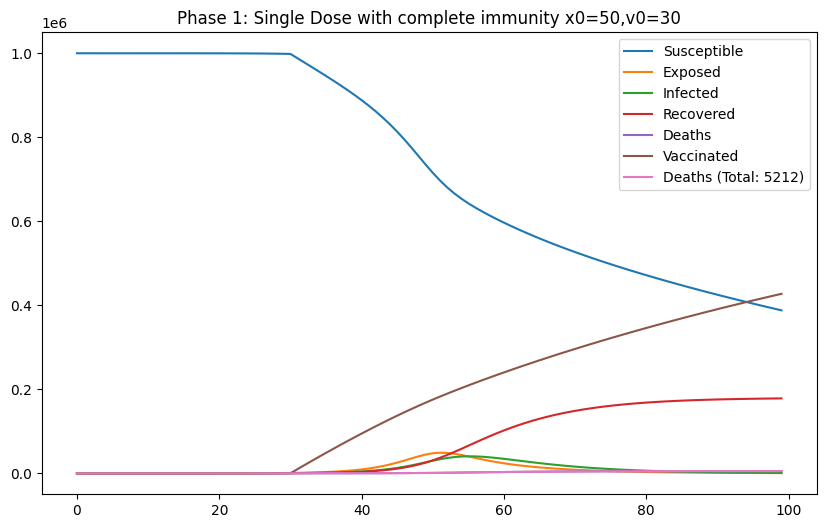

<Figure size 640x480 with 0 Axes>

In [22]:
t = np.linspace(0, 99, 100)
y0_phase1 = (N-1, 1, 0, 0, 0, 0)
ret = odeint(deriv_phase1, y0_phase1, t, args=(N, gamma, delta, rho, alpha))
S, E, I, R, D_final, V = ret.T
total_deaths = int(D_final[-1])

plt.figure(figsize=(10,6))
plt.plot(t, S, label="Susceptible")
plt.plot(t, E, label="Exposed")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.plot(t, D_final, label="Deaths")
plt.plot(t, V, label="Vaccinated")
plt.plot(t, D_final, label=f"Deaths (Total: {total_deaths})")
plt.legend()
plt.title("Phase 1: Single Dose with complete immunity x0="+str(x0)+",v0="+str(v01))
plt.show()
plt.savefig("Single Dose x0="+str(x0)+"_v0="+str(v01))